In [59]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import style
style.use(['dark_background', 'seaborn-dark-palette'])
import pandas as pd
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy import units as u
from astropy.table import QTable
import tarfile
import sqlite3
import lsst.daf.persistence as dafPersist
from lsst.daf.base import DateTime
#import diaObjectAnalysis as doa
#import plotLightcurve as plc
#import apdbPlots as pla
import scipy
sys.path.append('/epyc/users/mrawls/premap2019/ap_pipe-notebooks/')
from apdbPlots import makeSrcTableFlags
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [21]:
hitsDataDir='/epyc/users/mrawls/premap2019/hits-dr1'
hitsFilename='HiTS_DR1_variables_DM-dataset-subset.fits'
hitsFilepath=os.path.join(hitsDataDir,hitsFilename) # Creates file path to the HiTS DR1 database
hitsTable=fits.open(hitsFilepath) # Load data as an astropy fits thing
hitsDf=pd.DataFrame(hitsTable[1].data) # Turn data into a pandas dataframe

In [22]:
hitsDfQSO_filter = hitsDf[hitsDf['QSO_Prob'] > 0.80]
hitsDfQSO = hitsDfQSO_filter.drop(['Variable_prob', 'Periodic_prob', 'DSCT_Prob', 'EB_Prob', 'Predicted_class',
                                   'ROTVAR_Prob', 'RRLYR_Prob', 'CV_Prob', 'SNe_Prob'], axis = 1)

In [23]:
repo = '/epyc/users/mrawls/hits2015/rerun/cw_2020_02'
butler = dafPersist.Butler(repo) # Butler function retrieves the data
dbName = 'association.db'
dbPath = os.path.join(repo, dbName) # Joins repo and dbName to form a path to the database
connection = sqlite3.connect(dbPath) # Opens a connection to the database

# Read data from the database to pandas dataframes
objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources, \
                              gPSFluxMean, gPSFluxMeanErr, \
                              validityEnd, flags, \
                              gTOTFluxMean, gTOTFluxMeanErr \
                              from DiaObject where validityEnd is NULL;', connection) 
srcTableAll = pd.read_sql_query('select diaSourceId, diaObjectId, \
                                  ra, decl, ccdVisitId, \
                                  midPointTai, apFlux, psFlux, apFluxErr, \
                                  psFluxErr, totFlux, totFluxErr, flags \
                                  from DiaSource;', connection)

In [24]:
badFlagList = ['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_saturatedCenter'] 
flagTable, flagValues, srcTableFlags, flagFilter, noFlagFilter, \
    goodSrc, goodObj = makeSrcTableFlags(srcTableAll, objTable)

/epyc/users/mrawls/lsst_stack/stack/miniconda3-4.5.12-f032070/Linux64/ap_association/18.1.0-14-g371438c+1/python/lsst/ap/association/mapApData.py:388: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  table_list = list(yaml.load_all(yaml_stream))


In [25]:
lsstRas = goodObj.ra
lsstDecs = goodObj.decl
hitsRas = hitsDfQSO.raMedian_feat
hitsDecs = hitsDfQSO.decMedian_feat
# Convert HiTS and LSST coordinates to degrees
hitsCoords = SkyCoord(ra=hitsRas*u.degree, dec=hitsDecs*u.degree)
lsstCoords = SkyCoord(ra=lsstRas*u.degree, dec=lsstDecs*u.degree)
idx, d2d, d3d = hitsCoords.match_to_catalog_sky(lsstCoords)

In [26]:
def plot_objects_on_sky(ra1_first, dec1_first,
                        ra2_first, dec2_first,
                        ra1_second, dec1_second,
                        ra2_second, dec2_second):
    """This function takes two sets of RA and Dec and plots them
    both on the sky in different colors.
    
    It is customized to plot a specific region (three HiTS fields in two panels).
    
    "1" and "2" refer to the two panels in the plot.
    "first" and "second" refer to the two different datasets.
    """
    # Set up the figure object and two axes
    fig = plt.figure(figsize=(13, 13))
    ax1 = plt.subplot2grid((100, 100), (0, 55), rowspan=50, colspan=45)
    ax2 = plt.subplot2grid((100, 100), (0, 0), rowspan=90, colspan=50)

    # Plot the first set of RAs and Decs in blue
    # This will be from the LSST database
    ax1.scatter(ra1_first, dec1_first, marker='.', s=0.5, alpha=0.5, c='C0',label='LSST Objects')
    ax2.scatter(ra2_first, dec2_first, marker='.', s=0.5, alpha=0.5, c='C0',label='LSST Objects')
    
    # Plot the second set of RAs and Decs in red
    # This will be from the HiTS DR1
    ax1.scatter(ra1_second, dec1_second, marker='.', s=15, alpha=0.8, c='red',label='HiTS QSO')
    ax2.scatter(ra2_second, dec2_second, marker='.', s=15, alpha=0.8, c='red',label='HiTS QSO')

    ax1.invert_xaxis()
    ax2.invert_xaxis()
    
    # Label axes and title plot
    plt.xlabel('RA (deg)', fontsize=14)
    plt.ylabel('Dec (deg)', fontsize=14)
    plt.title('View of Objects from LSST and HiTS (QSOs) on the Sky', fontsize=15)
    
    # Increase x and y tick text size
    ax1.tick_params(axis='both', which='major', labelsize=11.5)
    ax1.tick_params(axis='both', which='minor', labelsize=11.5)

    ax2.tick_params(axis='both', which='major', labelsize=11.5)
    ax2.tick_params(axis='both', which='minor', labelsize=11.5)
    
    # Generate legends
    lgnd = ax1.legend(loc="lower right", scatterpoints=1, fontsize=10, prop={'size': 11.5})
    lgnd.legendHandles[0]._sizes = [60]
    lgnd.legendHandles[1]._sizes = [60]
    
    lgnd2 = ax2.legend(loc="lower right", scatterpoints=1, fontsize=10, prop={'size': 11.5})
    lgnd2.legendHandles[0]._sizes = [60]
    lgnd2.legendHandles[1]._sizes = [60]

In [27]:
# Defines filters and parameters to be called by plot_objects_on_sky()
ax1Filter = (goodObj['decl']>-2)
ax2Filter=(~ax1Filter)

ra1_first=goodObj.loc[ax1Filter, 'ra']
dec1_first=goodObj.loc[ax1Filter, 'decl']
ra2_first=goodObj.loc[ax2Filter, 'ra']
dec2_first=goodObj.loc[ax2Filter, 'decl']

ax1Filter_second = (hitsDf['decMedian']>-2)
ax2Filter_second = (~ax1Filter_second)

ra1_second=hitsDfQSO.loc[ax1Filter_second,'raMedian']
dec1_second=hitsDfQSO.loc[ax1Filter_second,'decMedian']
ra2_second=hitsDfQSO.loc[ax2Filter_second,'raMedian']
dec2_second=hitsDfQSO.loc[ax2Filter_second,'decMedian']

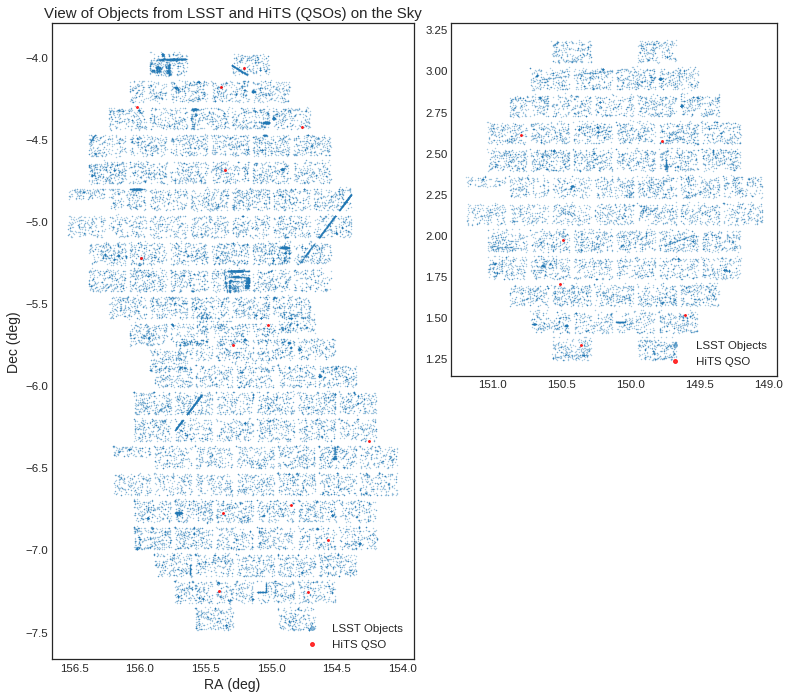

In [28]:
plot_objects_on_sky(ra1_first, dec1_first,
                        ra2_first, dec2_first,
                        ra1_second, dec1_second,
                        ra2_second, dec2_second)

## MILLIQUAS Plots

In [29]:
print(ra1_first.min(),ra1_first.max()) #smaller region
print(dec1_first.min(),dec1_first.max())

149.04444247539877 151.19580465580609
1.2409499195515765 3.189442826355616


In [30]:
print(ra2_first.min(),ra2_first.max()) #larger region
print(dec2_first.min(),dec2_first.max())

154.04249420420086 156.54527675227297
-7.491501929192215 -3.970179722848178


In [31]:
ra_min1= Angle(f'{ra1_first.min()}d', unit='hour')
ra_max1= Angle(f'{ra1_first.max()}d', unit='hour')
ra_min2= Angle(f'{ra2_first.min()}d', unit='hour')
ra_max2= Angle(f'{ra2_first.max()}d', unit='hour')
dec_min1 = Angle(f'{dec1_first.min()}d', unit='degree')
dec_max1 = Angle(f'{dec1_first.max()}d', unit='degree')
dec_min2 = Angle(f'{dec2_first.min()}d', unit='degree')
dec_max2 = Angle(f'{dec2_first.max()}d', unit='degree')

print(ra_min1,'|', ra_max1)
print(dec_min1,'|', dec_max1)
print('\n')
print(ra_min2,'|', ra_max2)
print(dec_min2,'|', dec_max2)

9h56m10.6662s | 10h04m46.9931s
1d14m27.4197s | 3d11m21.9942s


10h16m10.1986s | 10h26m10.8664s
-7d29m29.4069s | -3d58m12.647s


In [32]:
MILLI_sub1 = pd.read_csv('/epyc/users/tw94/lsst-hits-bump/mrawls/MILLI_QSO_region1.1584579832', 
                         sep = '|',header=2, usecols = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], na_values = '     ')
MILLI_sub1.head()

,ra,dec,bmag,rmag,redshift,radio_name,xray_name,lii,bii,broad_type,optical_flag,red_psf_flag,blue_psf_flag,ref_name,ref_redshift,qso_prob,class
0,09 57 40.50,+01 14 48.1,23.33,22.18,0.670,,,237.31840,40.99369,G2,g,1,1,0006,0006,99,GALAXY
1,09 57 23.69,+01 14 58.7,19.73,19.44,2.484,,,237.26096,40.93863,Q,jG,-,-,DR14Q,DR14Q,,QSO TYPE 1
2,10 03 05.70,+01 15 03.5,20.98,19.83,0.748,,,238.38186,42.08989,Q,pG,-,-,2QZ,2QZ,,QSO TYPE 1
3,10 00 18.59,+01 15 06.1,21.36,19.95,0.861,,,237.82779,41.52948,Q,pG,-,-,2QZ,2QZ,,QSO TYPE 1
4,09 56 47.47,+01 15 23.9,17.39,14.58,0.064,FIRST J095647.4+011523,,237.13686,40.82026,AR,p+G,1,1,PGC,DR16,100,AGN UNCLASSIFIED


In [33]:
for col in MILLI_sub1.columns: 
    print(col) 

ra         
dec        
bmag 
rmag 
redshift
radio_name            
xray_name             
lii      
bii     
broad_type
optical_flag
red_psf_flag
blue_psf_flag
ref_name
ref_redshift
qso_prob
class           


In [34]:
MILLI_sub1 = MILLI_sub1.rename(columns={"ra         ":"ra", "dec        ":"dec", "bmag ":"bmag", "rmag ":"rmag",
                                        "radio_name            ":"radio_name", "xray_name             ":"xray_name",
                                        "lii      ":"lii", "bii     ":"bii", "class           ":"class"})

In [35]:
MILLI_sub2 = pd.read_csv('/epyc/users/tw94/lsst-hits-bump/mrawls/MILLI_QSO_region2.1584579992', 
                         sep = '|',header=2, usecols = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], na_values = '     ')
MILLI_sub2.head()

,ra,dec,bmag,rmag,redshift,radio_name,xray_name,lii,bii,broad_type,optical_flag,red_psf_flag,blue_psf_flag,ref_name,ref_redshift,qso_prob,class
0,10 22 29.64,-07 29 24.5,20.54,19.62,0.600,,,251.35803,40.02174,q,pG,-,-,WISEA,MQ,91,QSO TYPE 1
1,10 24 39.74,-07 27 35.4,21.47,20.53,,,4XMM J102439.7-072736,251.83227,40.42006,X,jG,-,-,MORX,,93,UNIDENTIFIED
2,10 24 46.60,-07 25 18.8,21.76,NaN,,,4XMM J102446.5-072518,251.82411,40.46701,X,j,x,-,MORX,,83,UNIDENTIFIED
3,10 20 23.69,-07 25 09.6,20.66,19.48,0.600,,,250.81271,39.70461,q,pG,1,1,WISEA,MQ,88,QSO TYPE 1
4,10 24 15.60,-07 23 21.1,19.84,19.63,0.700,,4XMM J102415.6-072321,251.67378,40.40080,qX,pmG,-,-,WISEA,MQ,100,QSO TYPE 1


In [36]:
MILLI_sub2 = MILLI_sub2.rename(columns={"ra         ":"ra", "dec        ":"dec", "bmag ":"bmag", "rmag ":"rmag",
                                        "radio_name            ":"radio_name", "xray_name             ":"xray_name",
                                        "lii      ":"lii", "bii     ":"bii", "class           ":"class"})

In [37]:
MILLI_sub1['ra_deg']= (Angle(MILLI_sub1['ra'], unit ='hour')).deg
MILLI_sub1['dec_deg'] = (Angle(MILLI_sub1['dec'], unit ='degree')).deg
MILLI_sub1.head()

,ra,dec,bmag,rmag,redshift,radio_name,xray_name,lii,bii,broad_type,optical_flag,red_psf_flag,blue_psf_flag,ref_name,ref_redshift,qso_prob,class,ra_deg,dec_deg
0,09 57 40.50,+01 14 48.1,23.33,22.18,0.670,,,237.31840,40.99369,G2,g,1,1,0006,0006,99,GALAXY,149.418750,1.246694
1,09 57 23.69,+01 14 58.7,19.73,19.44,2.484,,,237.26096,40.93863,Q,jG,-,-,DR14Q,DR14Q,,QSO TYPE 1,149.348708,1.249639
2,10 03 05.70,+01 15 03.5,20.98,19.83,0.748,,,238.38186,42.08989,Q,pG,-,-,2QZ,2QZ,,QSO TYPE 1,150.773750,1.250972
3,10 00 18.59,+01 15 06.1,21.36,19.95,0.861,,,237.82779,41.52948,Q,pG,-,-,2QZ,2QZ,,QSO TYPE 1,150.077458,1.251694
4,09 56 47.47,+01 15 23.9,17.39,14.58,0.064,FIRST J095647.4+011523,,237.13686,40.82026,AR,p+G,1,1,PGC,DR16,100,AGN UNCLASSIFIED,149.197792,1.256639


In [38]:
MILLI_sub2['ra_deg']= (Angle(MILLI_sub2['ra'], unit ='hour')).deg
MILLI_sub2['dec_deg'] = (Angle(MILLI_sub2['dec'], unit ='degree')).deg
MILLI_sub2.head()

,ra,dec,bmag,rmag,redshift,radio_name,xray_name,lii,bii,broad_type,optical_flag,red_psf_flag,blue_psf_flag,ref_name,ref_redshift,qso_prob,class,ra_deg,dec_deg
0,10 22 29.64,-07 29 24.5,20.54,19.62,0.600,,,251.35803,40.02174,q,pG,-,-,WISEA,MQ,91,QSO TYPE 1,155.623500,-7.490139
1,10 24 39.74,-07 27 35.4,21.47,20.53,,,4XMM J102439.7-072736,251.83227,40.42006,X,jG,-,-,MORX,,93,UNIDENTIFIED,156.165583,-7.459833
2,10 24 46.60,-07 25 18.8,21.76,NaN,,,4XMM J102446.5-072518,251.82411,40.46701,X,j,x,-,MORX,,83,UNIDENTIFIED,156.194167,-7.421889
3,10 20 23.69,-07 25 09.6,20.66,19.48,0.600,,,250.81271,39.70461,q,pG,1,1,WISEA,MQ,88,QSO TYPE 1,155.098708,-7.419333
4,10 24 15.60,-07 23 21.1,19.84,19.63,0.700,,4XMM J102415.6-072321,251.67378,40.40080,qX,pmG,-,-,WISEA,MQ,100,QSO TYPE 1,156.065000,-7.389194


In [39]:
cols = MILLI_sub2.columns.tolist()

In [40]:
cols_reorder = ['ra', 'dec', 'ra_deg', 'dec_deg', 'bmag', 'rmag', 'redshift', 'radio_name', 'xray_name', 
                'lii', 'bii', 'broad_type', 'optical_flag', 'red_psf_flag', 'blue_psf_flag', 'ref_name', 
                'ref_redshift', 'qso_prob', 'class'] 
MILLI_sub1 = MILLI_sub1[cols_reorder]
MILLI_sub2 = MILLI_sub2[cols_reorder]

MILLI_sub1.head()

,ra,dec,ra_deg,dec_deg,bmag,rmag,redshift,radio_name,xray_name,lii,bii,broad_type,optical_flag,red_psf_flag,blue_psf_flag,ref_name,ref_redshift,qso_prob,class
0,09 57 40.50,+01 14 48.1,149.418750,1.246694,23.33,22.18,0.670,,,237.31840,40.99369,G2,g,1,1,0006,0006,99,GALAXY
1,09 57 23.69,+01 14 58.7,149.348708,1.249639,19.73,19.44,2.484,,,237.26096,40.93863,Q,jG,-,-,DR14Q,DR14Q,,QSO TYPE 1
2,10 03 05.70,+01 15 03.5,150.773750,1.250972,20.98,19.83,0.748,,,238.38186,42.08989,Q,pG,-,-,2QZ,2QZ,,QSO TYPE 1
3,10 00 18.59,+01 15 06.1,150.077458,1.251694,21.36,19.95,0.861,,,237.82779,41.52948,Q,pG,-,-,2QZ,2QZ,,QSO TYPE 1
4,09 56 47.47,+01 15 23.9,149.197792,1.256639,17.39,14.58,0.064,FIRST J095647.4+011523,,237.13686,40.82026,AR,p+G,1,1,PGC,DR16,100,AGN UNCLASSIFIED


##### Preliminary Plots

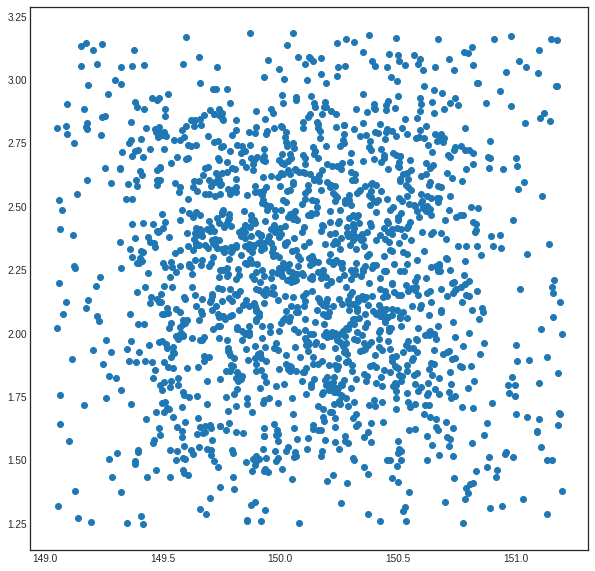

In [41]:
plt.figure(figsize = (10,10))
plt.scatter(MILLI_sub1['ra_deg'].values,MILLI_sub1['dec_deg'].values)

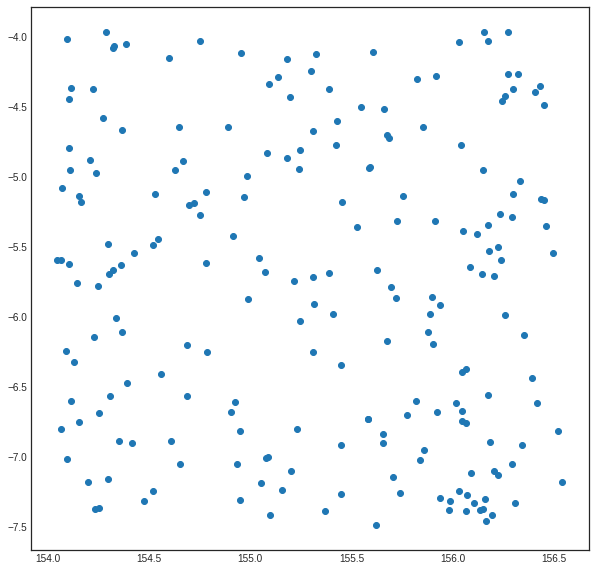

In [42]:
plt.figure(figsize = (10,10))
plt.scatter(MILLI_sub2['ra_deg'].values,MILLI_sub2['dec_deg'].values)

### Filtering to Visable and Plotting Objects on the Sky

In [43]:
MILLI_sub1_visible = MILLI_sub1.query('rmag < 23 and bmag < 23')
MILLI_sub2_visible = MILLI_sub2.query('rmag < 23 and bmag < 23')
print(len(MILLI_sub1), len(MILLI_sub1_visible))
print(len(MILLI_sub2), len(MILLI_sub2_visible))

1702 976
210 203


In [142]:
def plot_objects_on_sky2(ra1_first, dec1_first,
                        ra2_first, dec2_first,
                        ra1_second, dec1_second,
                        ra2_second, dec2_second,
                        ra1_third, dec1_third,
                        ra2_third, dec2_third):
    """This function takes three sets of RA and Dec and plots them
    both on the sky in different colors.
    
    It is customized to plot a specific region (three HiTS fields in two panels).
    
    "1" and "2" refer to the two panels in the plot.
    "first" and "second" refer to the two different datasets.
    """
    # Set up the figure object, title, and two axes
    fig = plt.figure(figsize=(12, 12))
    fig.suptitle('View of Objects from LSST, HiTS (QSOs), and MILLIQUAS on the Sky', x = 0.5, y= 0.9, fontsize=15)
    ax1 = plt.subplot2grid((100, 100), (0, 55), rowspan=50, colspan=45)
    ax2 = plt.subplot2grid((100, 100), (0, 0), rowspan=90, colspan=50)

    # Plot the first set of RAs and Decs in blue
    # This will be from the LSST database
    ax1.scatter(ra1_first, dec1_first, marker='.', s=0.5, alpha=0.3, c='white',label='LSST Objects')
    ax2.scatter(ra2_first, dec2_first, marker='.', s=0.5, alpha=0.3, c='white',label='LSST Objects')
    
    # Plot the second set of RAs and Decs in red
    # This will be from the HiTS DR1
    ax1.scatter(ra1_second, dec1_second, marker='.', s=17, alpha=1, c='cyan',label='HiTS QSO')
    ax2.scatter(ra2_second, dec2_second, marker='.', s=17, alpha=1, c='cyan',label='HiTS QSO')

    ax1.invert_xaxis()
    ax2.invert_xaxis()
    
    # Plot the third set of RAs and Decs in purple
    # This will be from the MILLIQUAS database
    ax1.scatter(ra1_third, dec1_third, marker = '.', s = 15, alpha = 0.6, c = 'blue', 
                label = 'MILLIQUAS QSO')
    ax2.scatter(ra2_third, dec2_third, marker = '.', s = 15, alpha = 0.6, c = 'blue', 
                label = 'MILLIQUAS QSO')
    
    
    # Label axes
    plt.xlabel('RA (deg)', fontsize=14)
    plt.ylabel('Dec (deg)', fontsize=14)
    
    # Increase x and y tick text size
    ax1.tick_params(axis='both', which='major', labelsize=11.5)
    ax1.tick_params(axis='both', which='minor', labelsize=11.5)

    ax2.tick_params(axis='both', which='major', labelsize=11.5)
    ax2.tick_params(axis='both', which='minor', labelsize=11.5)
    
    # Generate legends
    lgnd = ax1.legend(scatterpoints=1, fontsize=10, prop={'size': 11.5},bbox_to_anchor=(.69,-.38), loc = 'best')
    for lh in lgnd.legendHandles: 
        lh.set_alpha(1)
    lgnd.legendHandles[0]._sizes = [100]
    lgnd.legendHandles[0].set_color('white')
    lgnd.legendHandles[1]._sizes = [100]
    lgnd.legendHandles[2]._sizes = [100]
    
    #lgnd2 = ax2.legend(loc="lower right", scatterpoints=1, fontsize=10, prop={'size': 11.5})
    #lgnd2.legendHandles[0]._sizes = [60]
    #lgnd2.legendHandles[1]._sizes = [60]

In [134]:
ra1_third = MILLI_sub1_visible['ra_deg']
dec1_third = MILLI_sub1_visible['dec_deg']
ra2_third = MILLI_sub2_visible['ra_deg']
dec2_third = MILLI_sub2_visible['dec_deg']

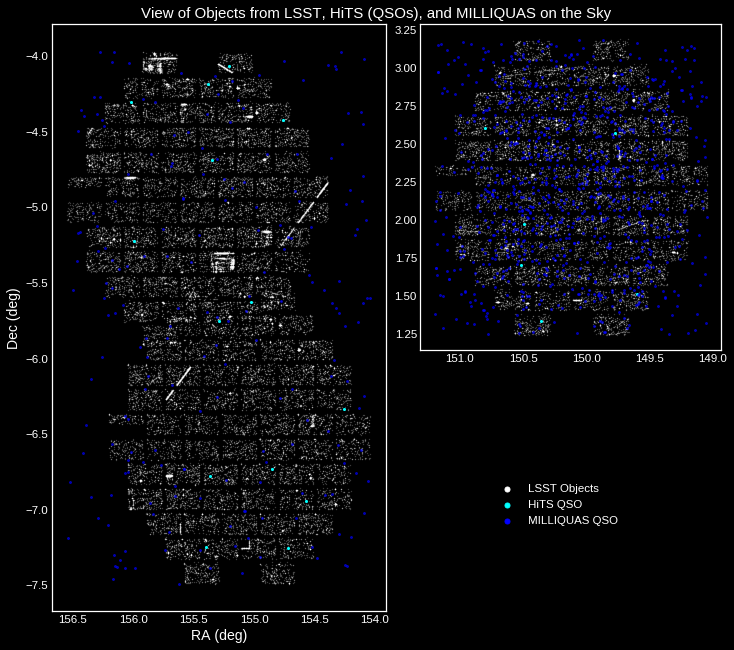

In [143]:
plot_objects_on_sky2(ra1_first, dec1_first,
                    ra2_first, dec2_first,
                    ra1_second, dec1_second,
                    ra2_second, dec2_second,
                    ra1_third, dec1_third,
                    ra2_third, dec2_third)

### Combining Dataframes

In [47]:
frames1 = [MILLI_sub1_visible, MILLI_sub2_visible]
MILLI_all_filtered = pd.concat(frames1)
MILLI_all_filtered.head()

,ra,dec,ra_deg,dec_deg,bmag,rmag,redshift,radio_name,xray_name,lii,bii,broad_type,optical_flag,red_psf_flag,blue_psf_flag,ref_name,ref_redshift,qso_prob,class
1,09 57 23.69,+01 14 58.7,149.348708,1.249639,19.73,19.44,2.484,,,237.26096,40.93863,Q,jG,-,-,DR14Q,DR14Q,,QSO TYPE 1
2,10 03 05.70,+01 15 03.5,150.773750,1.250972,20.98,19.83,0.748,,,238.38186,42.08989,Q,pG,-,-,2QZ,2QZ,,QSO TYPE 1
3,10 00 18.59,+01 15 06.1,150.077458,1.251694,21.36,19.95,0.861,,,237.82779,41.52948,Q,pG,-,-,2QZ,2QZ,,QSO TYPE 1
4,09 56 47.47,+01 15 23.9,149.197792,1.256639,17.39,14.58,0.064,FIRST J095647.4+011523,,237.13686,40.82026,AR,p+G,1,1,PGC,DR16,100,AGN UNCLASSIFIED
5,10 02 07.77,+01 15 27.2,150.532375,1.257556,21.19,20.37,2.517,,,238.18185,41.89966,Q,jG,1,-,DR14Q,DR14Q,,QSO TYPE 1


In [48]:
ra1 = MILLI_all_filtered['ra_deg']
dec1 = MILLI_all_filtered['dec_deg'] 
ra2 = goodObj['ra']
dec2 = goodObj['decl']

In [49]:
c = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)
catalog = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)

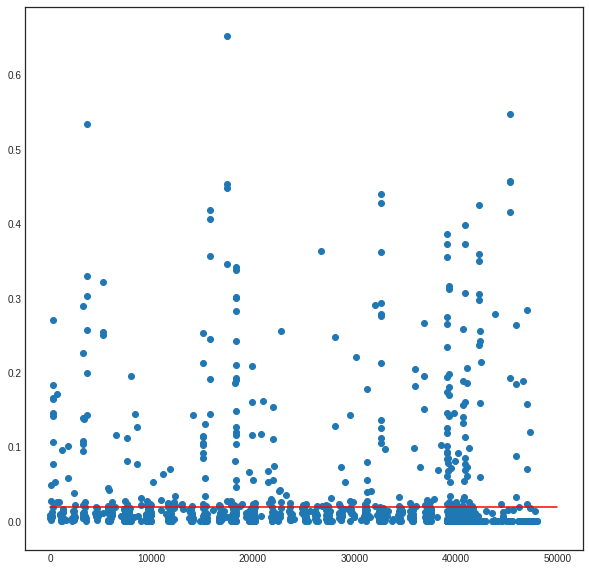

In [50]:
plt.figure(figsize = (10,10))
plt.scatter(idx,d2d)
x = [0,50000]
y = [0.02,0.02]
plt.plot(x,y, color = 'red')

Choose cutoff for distance and dia obj with 5 or more sources

In [51]:
goodSrc.head()

,diaSourceId,diaObjectId,ra,decl,ccdVisitId,midPointTai,apFlux,psFlux,apFluxErr,psFluxErr,...,slot_PsfFlux_flag_edge,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge,slot_Shape_flag,slot_Shape_flag_unweightedBad,slot_Shape_flag_unweighted,slot_Shape_flag_shift,slot_Shape_flag_maxIter,slot_Shape_flag_psf
4,176486665823453491,176486665823453491,149.512223,2.932614,41091504,57070.141866,-462.552054,-319.352917,781.301703,362.903789,...,False,False,False,False,True,False,True,False,False,False
7,176486665823453494,176486665823453494,149.516631,2.937590,41091504,57070.141866,119.281802,1781.097617,762.995909,297.408706,...,False,False,False,False,False,False,False,False,False,False
17,176486665823453504,176486665823453504,149.531164,2.906155,41091504,57070.141866,-1564.741537,-1893.969473,748.132398,282.299605,...,False,False,False,False,True,True,False,False,False,False
22,176486665823453509,176486665823453509,149.537025,2.941014,41091504,57070.141866,158.186198,-532.591733,898.829782,623.751322,...,False,False,False,False,True,True,False,False,False,False
32,176486665823453519,176486665823453519,149.551095,2.900996,41091504,57070.141866,-1772.948806,-1635.970189,763.061713,289.094486,...,False,False,False,False,True,True,False,False,False,False


In [52]:
ccdVisitIds = goodSrc['ccdVisitId']
dataIds = [{'visit': int(str(dataId)[0:6]), 'ccd': int(str(dataId)[6:])} for dataId in ccdVisitIds]

In [53]:
idx

array([39116, 18215,  3314, ..., 36855, 36855, 45351])

In [54]:
MILLI_all_filtered['idx'] = idx

In [55]:
MILLI_all_filtered['d2d_deg'] = d2d

In [56]:
MILLI_all_filtered.head()

,ra,dec,ra_deg,dec_deg,bmag,rmag,redshift,radio_name,xray_name,lii,...,broad_type,optical_flag,red_psf_flag,blue_psf_flag,ref_name,ref_redshift,qso_prob,class,idx,d2d_deg
1,09 57 23.69,+01 14 58.7,149.348708,1.249639,19.73,19.44,2.484,,,237.26096,...,Q,jG,-,-,DR14Q,DR14Q,,QSO TYPE 1,39116,0.234868
2,10 03 05.70,+01 15 03.5,150.773750,1.250972,20.98,19.83,0.748,,,238.38186,...,Q,pG,-,-,2QZ,2QZ,,QSO TYPE 1,18215,0.185993
3,10 00 18.59,+01 15 06.1,150.077458,1.251694,21.36,19.95,0.861,,,237.82779,...,Q,pG,-,-,2QZ,2QZ,,QSO TYPE 1,3314,0.137841
4,09 56 47.47,+01 15 23.9,149.197792,1.256639,17.39,14.58,0.064,FIRST J095647.4+011523,,237.13686,...,AR,p+G,1,1,PGC,DR16,100,AGN UNCLASSIFIED,39116,0.354526
5,10 02 07.77,+01 15 27.2,150.532375,1.257556,21.19,20.37,2.517,,,238.18185,...,Q,jG,1,-,DR14Q,DR14Q,,QSO TYPE 1,31159,0.000027


In [57]:
a = MILLI_all_filtered.query('d2d_deg < 0.05')['ra'].count()
b = MILLI_all_filtered.query('d2d_deg < 0.02')['ra'].count()
c = MILLI_all_filtered.query('d2d_deg < 0.01')['ra'].count()
d = MILLI_all_filtered.query('d2d_deg < 0.001')['ra'].count()
e = MILLI_all_filtered.query('d2d_deg < 0.0001')['ra'].count()
f = MILLI_all_filtered.query('d2d_deg < 0.00001')['ra'].count()

print(f'The total number of visible MILLIQUAS QSOs is {len(MILLI_all_filtered)}.')
print(f'QSOs with distance < 0.05 deg = {a}')
print(f'QSOs with distance < 0.02 deg = {b}')
print(f'QSOs with distance < 0.01 deg = {c}')
print(f'QSOs with distance < 0.001 deg = {d}')
print(f'QSOs with distance < 0.0001 deg = {e}')
print(f'QSOs with distance < 0.00001 deg = {f}')

The total number of visible MILLIQUAS QSOs is 1179.
QSOs with distance < 0.05 deg = 982
QSOs with distance < 0.02 deg = 880
QSOs with distance < 0.01 deg = 665
QSOs with distance < 0.001 deg = 363
QSOs with distance < 0.0001 deg = 317
QSOs with distance < 0.00001 deg = 14


In [58]:
ra2 = MILLI_all_close['ra_deg']
dec2 = MILLI_all_close['dec_deg'] 
ra3 = goodObj['ra']
dec3 = goodObj['decl']

NameError: name 'MILLI_all_close' is not defined

In [ ]:
c2 = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
catalog2 = SkyCoord(ra=ra3*u.degree, dec=dec3*u.degree)
idx2, d2d2, d3d2 = c2.match_to_catalog_sky(catalog2)

In [ ]:
goodObj.head()

In [ ]:
idx2

In [ ]:
diaObjectIdQSO = goodObj['diaObjectId'].iloc[idx] #Hopefully these are the right ones?

In [ ]:
MILLI_all_filtered['diaObjectId'] = diaObjectIdQSO.values


In [ ]:
MILLI_all_filtered

In [ ]:
MILLI_all_filtered.query('d2d_deg < 0.00001')

#### Light Curves

In [ ]:
def plotLSSTLightcurve(diaObjectId, dbPath='/epyc/users/mrawls/hits2015/rerun/cw_2020_02/association.db'):
    '''Plot a light curve for a DIA (Difference Image Analysis) Object
    from an LSST APDB (Alert Production database).
    
    Parameters
    ----------
    diaObjectId : Identifier for an LSST DIA object
    
    dbPath : Path on disk to an APDB we can load DIA Objects or DIA Sources from
        often the database is named `association.db`

    '''
        
    # Load all sources for this object only
    connection = sqlite3.connect(dbPath)
    forcedSrcTable = pd.read_sql_query(f'select diaObjectId, midPointTai, psFlux, psFluxErr, totFlux, totFluxErr \
                                       from DiaForcedSource where diaObjectId = {diaObjectId};', connection)
    srcTable = pd.read_sql_query(f'select diaObjectId, midPointTai, ccdVisitId, psFlux, psFluxErr, totFlux, totFluxErr \
                                 from DiaSource where diaObjectId = {diaObjectId};', connection)

    # Convert flux to magnitude
    #mags = (np.array(forcedSrcTable['totFlux'])*u.nJy).to(u.ABmag)
    #magErrs = 1.0857 / forcedSrcTable['totFluxErr'] / forcedSrcTable['totFlux']
    #forcedSrcTable['mags'] = mags
    #forcedSrcTable['magErrs'] = magErrs
    
    #mags = (np.array(srcTable['totFlux'])*u.nJy).to(u.ABmag)
    #magErrs = 1.0857 / srcTable['totFluxErr'] / srcTable['totFlux']
    #srcTable['mags'] = mags
    #srcTable['magErrs'] = magErrs
    
    plt.figure(figsize=(10,4))
    
  
  
    # Plot the LSST light curve (forced PSF photometry on calexp at DIASource position)
    plt.errorbar(srcTable['midPointTai'], srcTable['totFlux'], 
                 yerr=srcTable['totFluxErr'], ls=':', marker='o', label='LSST Source', color='C0')
    
    # Plot the LSST light curve (forced PSF photometry on calexp at DIAObject position)
    #plt.errorbar(forcedSrcTable['midPointTai'], forcedSrcTable['totFlux'], 
     #            yerr=forcedSrcTable['totFluxErr'], ls=':', marker='o', label='LSST', color='C0')
    
    # Plot the LSST light curve directly from source catalogs
    #if plotSourceCatLightCurve:
       # objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources \
        #                      from DiaObject where validityEnd is NULL;', connection)
       # sourceCatTimes, sourceCatMags, sourceCatMagErrs = getSourceCatLightCurve(obj, objTable, srcTable, butler)
       # plt.errorbar(sourceCatTimes, sourceCatMags, yerr=sourceCatMagErrs, ls=':', marker='o', label='LSST SourceCat', color='C2')
    
    

    # Add some plot labels, and reverse the y-axis so bright stuff is at the top
    plt.xlabel('Time (MJD)')
    plt.ylabel('Instantaneous Flux (nJy)')
    #plt.legend(frameon=False, prop={'size': 16})

In [ ]:
for obj in MILLI_all_filtered['diaObjectId'].loc[MILLI_all_filtered['d2d_deg'] < 0.00001]:
     plotLSSTLightcurve(obj)

In [ ]:
MILLI_all_filtered.to_csv('/epyc/users/tw94/lsst-hits-bump/mrawls/MILLI_all_filtered.csv', index = False)

In [ ]:
v = 1
d = 1
x = np.linspace(0,100)
y = v*(x/d)**(4/3)
y2 = v*(x/d)

In [ ]:
plt.plot(x,y)
plt.plot(x,y2,linestyle = '--')
plt.xlim(0,100)
plt.ylim(0,500)